In [1]:
# put this in it's own codeblock because it'll keep 
# running otherwise and eventually move to the root dir lol
%cd ..

/Users/angus/code/jupyter/env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/angus/code/jupyter/notebooks/20240907, vg


# Readme

In [11]:
from lib.service.database import DatabaseServiceImpl
from lib.defaults import INSTANCE_CFG
import os

db = DatabaseServiceImpl.create(INSTANCE_CFG[1].database, 1)
await db.wait_till_running()

engine = db.engine()

In [144]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import AnchoredText
from matplotlib.transforms import Affine2D
import numpy as np
from shapely.affinity import rotate
from sqlalchemy import text
import warnings

plt.rcParams['font.family'] = 'Georgia'

def create_source_annonation(src_loc: str, lv: bool = True, shapes: bool = True):
    text = '\n'.join(t for t in [
        "Created by Angus Thomsen (@Angus_KST)",
        "Source: NSW Valuer General, published November 2024 accessed 2025" if lv else '',
        "Shapes: ABS Australian Bureau of Statistics & NSW Spatial" if shapes else '',
    ] if t)
    source_box = AnchoredText(text,
        loc=src_loc,
        prop=dict(size=9),
        frameon=True,  # Draw a box around the text
    )
    source_box.patch.set_boxstyle("round,pad=0")
    source_box.patch.set_edgecolor("white")
    source_box.patch.set_facecolor("white")
    return source_box

async def execute(query):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        async with db.async_connect() as conn:
            await conn.execute(query);
            await conn.commit();

def read_postgis(sql: str):
    return gpd.read_postgis(text(sql), engine, geom_col='geometry').to_crs("EPSG:3857")

def plot_croydon(gdf, title: str, fname, credit_lv=True):
    rotation_angle = -70
    angle_radians = np.deg2rad(rotation_angle)
    arrow_length = 0.1  # Adjust this based on the scale of your plot
    x, y = 0.05, 0.85

    
    fig, ax = plt.subplots(figsize=(15, 8))
    centre = gdf.unary_union.centroid
    gdf_rotated = gdf.copy()
    gdf_rotated["geometry"] = gdf["geometry"]\
        .apply(lambda geom: rotate(geom, rotation_angle, origin=(centre.x, centre.y)))

    gdf_rotated.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=0.5)
    ax.set_title(title, fontsize=20, fontweight='bold')
        
    dx = 0
    dya, dy = arrow_length *0.25, arrow_length
    a_rdx = dx * np.cos(angle_radians) - dya * np.sin(angle_radians)
    a_rdy = dx * np.sin(angle_radians) + dya * np.cos(angle_radians)
    b_rdx = dx * np.cos(angle_radians) - dy * np.sin(angle_radians)
    b_rdy = dx * np.sin(angle_radians) + dy * np.cos(angle_radians)
    
    arrow = FancyArrowPatch((x + a_rdx, y + a_rdy), (x + b_rdx, y + b_rdy),
                            transform=ax.transAxes, color='black', linewidth=2,
                            arrowstyle='-|>', mutation_scale=30)
    ax.add_patch(arrow)
    ax.text(x, y, ' N', transform=ax.transAxes, 
        ha='center', va='center', fontsize=20, fontweight='bold')
    ax.add_artist(create_source_annonation('lower left', lv=credit_lv))
    fig.savefig(f"_out_img/20250212-croydon-{fname}.png")
    plt.show()
    

/var/folders/l1/1wl5vmds75qfv945_bs13x6w0000gn/T/ipykernel_26489/1449138582.py:47: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centre = gdf.unary_union.centroid


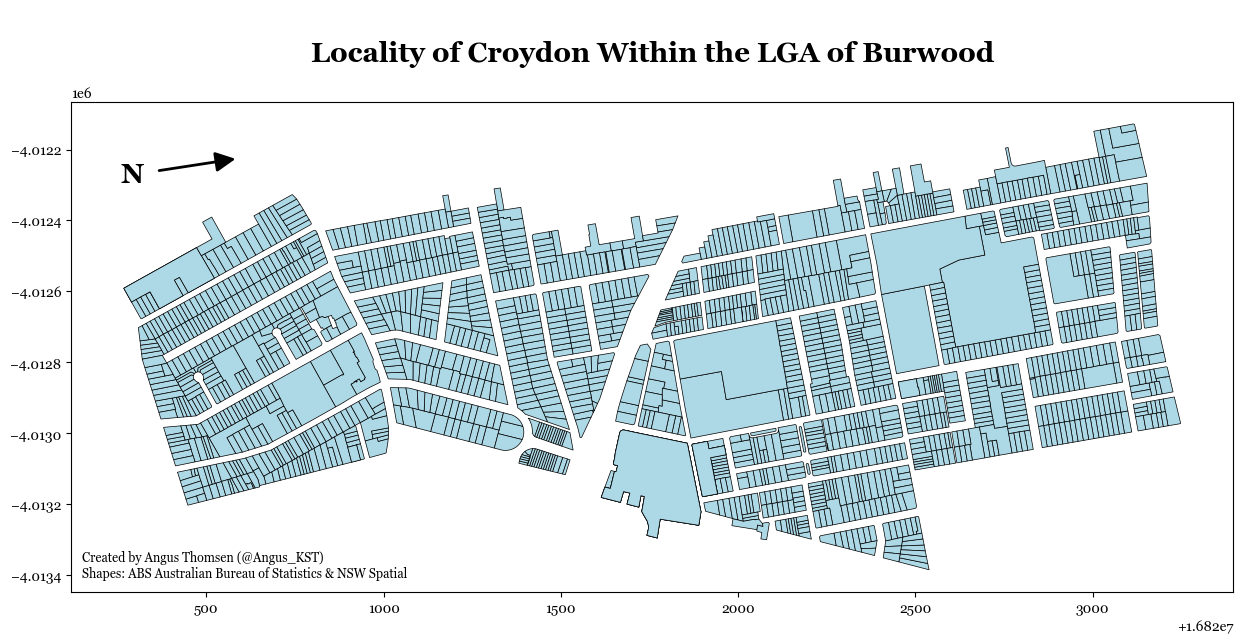

In [145]:
import geopandas as gpd

df_l = read_postgis("select * from abs.localities where locality_name = 'Croydon (NSW)'")

df_p = read_postgis("""
  SELECT p_geo.*, z.*
    FROM (select * from abs.localities where locality_name = 'Croydon (NSW)') l
    JOIN (select geometry from abs.lga_2024 where lga_name = 'Burwood') lga ON TRUE
    LEFT JOIN nsw_lrs.property_geometry p_geo ON ST_Intersects(p_geo.geometry, l.geometry)
    LEFT JOIN LATERAL (
      SELECT z.zone_code FROM nsw_lrs.zone_observation z WHERE z.property_id = p_geo.property_id
      ORDER BY z.effective_date DESC LIMIT 1) z ON TRUE
    WHERE (z.zone_code IS NOT NULL OR z.zone_code NOT IN ('SP1'))
      AND (ST_Within(p_geo.geometry, lga.geometry) OR (
       (ST_Area(ST_Intersection(p_geo.geometry, lga.geometry)) / ST_Area(p_geo.geometry)) > 0.75
      ))
""")

plot_croydon(df_p, 
             title='\nLocality of Croydon Within the LGA of Burwood\n',
             fname='suburb-within-lga',
             # no land value data
             credit_lv=False)